In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
import optuna.integration.lightgbm as lgb
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
import seaborn as sns
import warnings

In [3]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [4]:
data_dir = Path('./input')
feature_dir = Path('./input')
val_dir = Path('./input/val')
tst_dir = Path('./input/tst')
sub_dir = Path('./input/sub')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 42

In [5]:
algo_name = 'lgb_optuna'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [6]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 20)


,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,airmass_u,class,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det
id,,,,,,,,,,,,,,,,,,,,
0,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,2.9444,1.1898,0.0,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,-2.6257,-3.3488,2.0462,0.7232,-15.0556
1,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,0.6931,1.2533,1.0,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,-0.7683,-0.8698,0.2767,0.1016,-0.3069
2,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,1.0986,1.0225,0.0,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,-0.3649,-0.3905,0.1440,0.0257,-0.9014
3,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,1.6094,1.2054,0.0,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,-1.2000,-1.4395,0.5321,0.2395,-1.3906
4,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,2.6391,1.1939,0.0,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,-2.2436,-2.5579,0.9871,0.3144,-9.3609


In [7]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 19) (80000, 19)


## Hyperparameter Tuning

In [9]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=seed)

In [10]:
params = {
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 3,
    "n_estimators": 1000,
    "subsample_freq": 1,
    "lambda_l1": 0.,
    "lambda_l2": 0.,
    "random_state": seed,
    "n_jobs": -1,
}

In [11]:
dtrain = lgb.Dataset(X_trn, label=y_trn)
dval = lgb.Dataset(X_val, label=y_val)

model = lgb.train(params, dtrain, valid_sets=[dtrain, dval], 
                  verbose_eval=100, early_stopping_rounds=10)

prediction = np.argmax(model.predict(X_val, num_iteration=model.best_iteration), 
                       axis=1)
accuracy = accuracy_score(y_val, prediction)

params = model.params
print("Best params:", params)
print("  Accuracy = {}".format(accuracy))
print("  Params: ")
for key, value in params.items():
    print("    {}: {}".format(key, value))

[I 2021-01-18 18:51:32,120] A new study created in memory with name: no-name-e725064a-efce-48e6-ab35-14b2b6548a7d
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.170962:  14%|#4        | 1/7 [00:06<00:38,  6.39s/it]

Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.158753	valid_1's multi_logloss: 0.170962
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.169923:  29%|##8       | 2/7 [00:13<00:35,  7.06s/it]

[100]	valid_0's multi_logloss: 0.154919	valid_1's multi_logloss: 0.170396
Early stopping, best iteration is:
[92]	valid_0's multi_logloss: 0.156424	valid_1's multi_logloss: 0.169923
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.169923:  43%|####2     | 3/7 [00:19<00:26,  6.51s/it]

Early stopping, best iteration is:
[85]	valid_0's multi_logloss: 0.158623	valid_1's multi_logloss: 0.170672
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.158717	valid_1's multi_logloss: 0.17132
[200]	valid_0's multi_logloss: 0.143188	valid_1's multi_logloss: 0.166106
[300]	valid_0's multi_logloss: 0.133515	valid_1's multi_logloss: 0.164868
[400]	valid_0's multi_logloss: 0.125581	valid_1's multi_logloss: 0.164113
Early stopping, best iteration is:
[440]	valid_0's multi_logloss: 0.122699	valid_

feature_fraction, val_score: 0.163875:  57%|#####7    | 4/7 [00:43<00:40, 13.35s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.155774	valid_1's multi_logloss: 0.169529
[200]	valid_0's multi_logloss: 0.141269	valid_1's multi_logloss: 0.165328
[300]	valid_0's multi_logloss: 0.13149	valid_1's multi_logloss: 0.164003
[400]	valid_0's multi_logloss: 0.123577	valid_1's multi_logloss: 0.163539
Early stopping, best iteration is:
[390]	valid_0's multi_logloss: 0.124258	valid_1's multi_logloss: 0.163535


feature_fraction, val_score: 0.163535:  71%|#######1  | 5/7 [01:03<00:31, 15.75s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.157483	valid_1's multi_logloss: 0.170786


feature_fraction, val_score: 0.163535:  86%|########5 | 6/7 [01:09<00:12, 12.48s/it]

Early stopping, best iteration is:
[101]	valid_0's multi_logloss: 0.157261	valid_1's multi_logloss: 0.170664
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.16272	valid_1's multi_logloss: 0.174574


num_leaves, val_score: 0.163535:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[144]	valid_0's multi_logloss: 0.153295	valid_1's multi_logloss: 0.170086
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.156324	valid_1's multi_logloss: 0.169626


num_leaves, val_score: 0.163535:   5%|5         | 1/20 [00:07<02:16,  7.18s/it]

Early stopping, best iteration is:
[111]	valid_0's multi_logloss: 0.154271	valid_1's multi_logloss: 0.168931
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.117666	valid_1's multi_logloss: 0.163302
Early stopping, best iteration is:
[124]	valid_0's multi_logloss: 0.109819	valid_1's multi_logloss: 0.162984


num_leaves, val_score: 0.162984:  10%|#         | 2/20 [00:19<02:59, 10.00s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.187751	valid_1's multi_logloss: 0.19218
[200]	valid_0's multi_logloss: 0.171533	valid_1's multi_logloss: 0.178355


num_leaves, val_score: 0.162984:  15%|#5        | 3/20 [00:31<03:05, 10.89s/it]

Early stopping, best iteration is:
[230]	valid_0's multi_logloss: 0.168893	valid_1's multi_logloss: 0.176671
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.121639	valid_1's multi_logloss: 0.163396
Early stopping, best iteration is:
[123]	valid_0's multi_logloss: 0.114445	valid_1's multi_logloss: 0.163075


num_leaves, val_score: 0.162984:  20%|##        | 4/20 [00:40<02:45, 10.37s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.0993984	valid_1's multi_logloss: 0.162652
Early stopping, best iteration is:
[101]	valid_0's multi_logloss: 0.0990076	valid_1's multi_logloss: 0.162646


num_leaves, val_score: 0.162646:  25%|##5       | 5/20 [00:50<02:34, 10.31s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.113822	valid_1's multi_logloss: 0.162953
Early stopping, best iteration is:
[108]	valid_0's multi_logloss: 0.110929	valid_1's multi_logloss: 0.162714


num_leaves, val_score: 0.162646:  30%|###       | 6/20 [01:00<02:22, 10.21s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.133589	valid_1's multi_logloss: 0.164723
[200]	valid_0's multi_logloss: 0.111739	valid_1's multi_logloss: 0.163411
Early stopping, best iteration is:
[207]	valid_0's multi_logloss: 0.110495	valid_1's multi_logloss: 0.163343


num_leaves, val_score: 0.162646:  35%|###5      | 7/20 [01:15<02:31, 11.68s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.103316	valid_1's multi_logloss: 0.163046
Early stopping, best iteration is:
[102]	valid_0's multi_logloss: 0.102537	valid_1's multi_logloss: 0.162995


num_leaves, val_score: 0.162646:  40%|####      | 8/20 [01:26<02:15, 11.30s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.170732	valid_1's multi_logloss: 0.178284


num_leaves, val_score: 0.162646:  45%|####5     | 9/20 [01:33<01:51, 10.13s/it]

Early stopping, best iteration is:
[137]	valid_0's multi_logloss: 0.164505	valid_1's multi_logloss: 0.174041
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.101908	valid_1's multi_logloss: 0.162748
Early stopping, best iteration is:
[110]	valid_0's multi_logloss: 0.0979865	valid_1's multi_logloss: 0.162627


num_leaves, val_score: 0.162627:  50%|#####     | 10/20 [01:44<01:42, 10.20s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.107054	valid_1's multi_logloss: 0.163019
Early stopping, best iteration is:
[121]	valid_0's multi_logloss: 0.0995235	valid_1's multi_logloss: 0.162871


num_leaves, val_score: 0.162627:  55%|#####5    | 11/20 [04:18<08:10, 54.50s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.0961028	valid_1's multi_logloss: 0.16337
Early stopping, best iteration is:
[92]	valid_0's multi_logloss: 0.0996437	valid_1's multi_logloss: 0.163274


num_leaves, val_score: 0.162627:  60%|######    | 12/20 [04:30<05:32, 41.52s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.0961028	valid_1's multi_logloss: 0.16337
Early stopping, best iteration is:
[92]	valid_0's multi_logloss: 0.0996437	valid_1's multi_logloss: 0.163274


num_leaves, val_score: 0.162627:  65%|######5   | 13/20 [04:39<03:41, 31.64s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.102624	valid_1's multi_logloss: 0.16293
Early stopping, best iteration is:
[108]	valid_0's multi_logloss: 0.0991651	valid_1's multi_logloss: 0.162811


num_leaves, val_score: 0.162627:  70%|#######   | 14/20 [06:59<06:26, 64.41s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.0961258	valid_1's multi_logloss: 0.163032
Early stopping, best iteration is:
[92]	valid_0's multi_logloss: 0.0997378	valid_1's multi_logloss: 0.162945


num_leaves, val_score: 0.162627:  75%|#######5  | 15/20 [07:09<03:59, 47.82s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.108901	valid_1's multi_logloss: 0.162828
Early stopping, best iteration is:
[115]	valid_0's multi_logloss: 0.103376	valid_1's multi_logloss: 0.162618


num_leaves, val_score: 0.162618:  80%|########  | 16/20 [07:18<02:25, 36.26s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.110482	valid_1's multi_logloss: 0.162693
Early stopping, best iteration is:
[115]	valid_0's multi_logloss: 0.105165	valid_1's multi_logloss: 0.162498


num_leaves, val_score: 0.162498:  85%|########5 | 17/20 [07:29<01:25, 28.52s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.110482	valid_1's multi_logloss: 0.162693
Early stopping, best iteration is:
[115]	valid_0's multi_logloss: 0.105165	valid_1's multi_logloss: 0.162498


num_leaves, val_score: 0.162498:  90%|######### | 18/20 [07:38<00:45, 22.88s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.131332	valid_1's multi_logloss: 0.163987


num_leaves, val_score: 0.162498:  95%|#########5| 19/20 [07:49<00:19, 19.07s/it]

Early stopping, best iteration is:
[155]	valid_0's multi_logloss: 0.117694	valid_1's multi_logloss: 0.163156
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.110396	valid_1's multi_logloss: 0.163379
Early stopping, best iteration is:
[119]	valid_0's multi_logloss: 0.103532	valid_1's multi_logloss: 0.163152


bagging, val_score: 0.162498:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.110183	valid_1's multi_logloss: 0.162972
Early stopping, best iteration is:
[121]	valid_0's multi_logloss: 0.102822	valid_1's multi_logloss: 0.162799


bagging, val_score: 0.162498:  10%|#         | 1/10 [00:12<01:49, 12.11s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.110566	valid_1's multi_logloss: 0.163657
Early stopping, best iteration is:
[109]	valid_0's multi_logloss: 0.107077	valid_1's multi_logloss: 0.163552


bagging, val_score: 0.162498:  20%|##        | 2/10 [00:21<01:25, 10.67s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.111741	valid_1's multi_logloss: 0.164558
Early stopping, best iteration is:
[100]	valid_0's multi_logloss: 0.111741	valid_1's multi_logloss: 0.164558


bagging, val_score: 0.162498:  30%|###       | 3/10 [00:32<01:14, 10.67s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.110357	valid_1's multi_logloss: 0.163002
Early stopping, best iteration is:
[110]	valid_0's multi_logloss: 0.106553	valid_1's multi_logloss: 0.162835


bagging, val_score: 0.162498:  40%|####      | 4/10 [00:43<01:04, 10.83s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.110253	valid_1's multi_logloss: 0.163147
Early stopping, best iteration is:
[109]	valid_0's multi_logloss: 0.106837	valid_1's multi_logloss: 0.163044


bagging, val_score: 0.162498:  50%|#####     | 5/10 [00:53<00:53, 10.62s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.110165	valid_1's multi_logloss: 0.163031
Early stopping, best iteration is:
[115]	valid_0's multi_logloss: 0.104711	valid_1's multi_logloss: 0.162861


bagging, val_score: 0.162498:  60%|######    | 6/10 [01:05<00:43, 10.96s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.11018	valid_1's multi_logloss: 0.163455
Early stopping, best iteration is:
[104]	valid_0's multi_logloss: 0.10858	valid_1's multi_logloss: 0.163405


bagging, val_score: 0.162498:  70%|#######   | 7/10 [01:15<00:32, 10.81s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.111669	valid_1's multi_logloss: 0.164632
Early stopping, best iteration is:
[94]	valid_0's multi_logloss: 0.114212	valid_1's multi_logloss: 0.164589


bagging, val_score: 0.162498:  80%|########  | 8/10 [01:24<00:20, 10.24s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.112391	valid_1's multi_logloss: 0.164756
Early stopping, best iteration is:
[100]	valid_0's multi_logloss: 0.112391	valid_1's multi_logloss: 0.164756


bagging, val_score: 0.162498:  90%|######### | 9/10 [01:34<00:10, 10.18s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.109912	valid_1's multi_logloss: 0.162818
Early stopping, best iteration is:
[97]	valid_0's multi_logloss: 0.111143	valid_1's multi_logloss: 0.162776


feature_fraction_stage2, val_score: 0.162498:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.111294	valid_1's multi_logloss: 0.163262
Early stopping, best iteration is:
[109]	valid_0's multi_logloss: 0.107954	valid_1's multi_logloss: 0.163061


feature_fraction_stage2, val_score: 0.162498:  17%|#6        | 1/6 [00:09<00:46,  9.37s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.111294	valid_1's multi_logloss: 0.163262
Early stopping, best iteration is:
[109]	valid_0's multi_logloss: 0.107954	valid_1's multi_logloss: 0.163061


feature_fraction_stage2, val_score: 0.162498:  33%|###3      | 2/6 [00:18<00:37,  9.35s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.109866	valid_1's multi_logloss: 0.162736
Early stopping, best iteration is:
[111]	valid_0's multi_logloss: 0.10579	valid_1's multi_logloss: 0.162643


feature_fraction_stage2, val_score: 0.162498:  50%|#####     | 3/6 [00:28<00:28,  9.35s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.110482	valid_1's multi_logloss: 0.162693
Early stopping, best iteration is:
[115]	valid_0's multi_logloss: 0.105165	valid_1's multi_logloss: 0.162498


feature_fraction_stage2, val_score: 0.162498:  67%|######6   | 4/6 [00:38<00:19,  9.60s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.109866	valid_1's multi_logloss: 0.162736
Early stopping, best iteration is:
[111]	valid_0's multi_logloss: 0.10579	valid_1's multi_logloss: 0.162643


feature_fraction_stage2, val_score: 0.162498:  83%|########3 | 5/6 [00:47<00:09,  9.51s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.10948	valid_1's multi_logloss: 0.163027
Early stopping, best iteration is:
[96]	valid_0's multi_logloss: 0.110942	valid_1's multi_logloss: 0.162971


regularization_factors, val_score: 0.162498:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.110493	valid_1's multi_logloss: 0.163065
Early stopping, best iteration is:
[107]	valid_0's multi_logloss: 0.10772	valid_1's multi_logloss: 0.16283


regularization_factors, val_score: 0.162498:   5%|5         | 1/20 [00:09<03:00,  9.50s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's multi_logloss: 0.110506	valid_1's multi_logloss: 0.16313
Early stopping, best iteration is:
[108]	valid_0's multi_logloss: 0.107617	valid_1's multi_logloss: 0.162926


regularization_factors, val_score: 0.162498:  10%|#         | 2/20 [00:18<02:50,  9.47s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

regularization_factors, val_score: 0.162498:  15%|#5        | 3/20 [00:28<02:45,  9.73s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.110381	valid_1's multi_logloss: 0.163201
Early stopping, best iteration is:
[109]	valid_0's multi_logloss: 0.107108	valid_1's multi_logloss: 0.163074


regularization_factors, val_score: 0.162498:  20%|##        | 4/20 [00:38<02:34,  9.66s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.110655	valid_1's multi_logloss: 0.163201
Early stopping, best iteration is:
[102]	valid_0's multi_logloss: 0.109948	valid_1's multi_logloss: 0.163188


regularization_factors, val_score: 0.162498:  25%|##5       | 5/20 [00:48<02:27,  9.80s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.110216	valid_1's multi_logloss: 0.16327
Early stopping, best iteration is:
[105]	valid_0's multi_logloss: 0.108392	valid_1's multi_logloss: 0.163205


regularization_factors, val_score: 0.162498:  30%|###       | 6/20 [03:02<12:08, 52.01s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.110503	valid_1's multi_logloss: 0.163207
Early stopping, best iteration is:
[110]	valid_0's multi_logloss: 0.106785	valid_1's multi_logloss: 0.163014


regularization_factors, val_score: 0.162498:  35%|###5      | 7/20 [03:12<08:17, 38.24s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

regularization_factors, val_score: 0.162182:  40%|####      | 8/20 [03:23<05:54, 29.50s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's multi_logloss: 0.110842	valid_1's multi_logloss: 0.163231
Early stopping, best iteration is:


regularization_factors, val_score: 0.162182:  45%|####5     | 9/20 [03:32<04:14, 23.18s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

regularization_factors, val_score: 0.162182:  50%|#####     | 10/20 [03:45<03:19, 19.94s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

regularization_factors, val_score: 0.162182:  55%|#####5    | 11/20 [03:58<02:41, 17.91s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

regularization_factors, val_score: 0.162182:  60%|######    | 12/20 [04:14<02:17, 17.23s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

regularization_factors, val_score: 0.162182:  65%|######5   | 13/20 [04:24<01:46, 15.20s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

regularization_factors, val_score: 0.161749:  70%|#######   | 14/20 [04:37<01:27, 14.61s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's multi_logloss: 0.110394	valid_1's multi_logloss: 0.162719
Early stopping, best iteration is:
[109]	valid_0's multi_logloss: 0.107036	valid_1's multi_logloss: 0.162456


regularization_factors, val_score: 0.161749:  75%|#######5  | 15/20 [04:47<01:05, 13.18s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.110564	valid_1's multi_logloss: 0.163219
Early stopping, best iteration is:
[118]	valid_0's multi_logloss: 0.104139	valid_1's multi_logloss: 0.163008


regularization_factors, val_score: 0.161749:  80%|########  | 16/20 [04:58<00:49, 12.28s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

regularization_factors, val_score: 0.161749:  85%|########5 | 17/20 [05:08<00:34, 11.64s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's multi_logloss: 0.110561	valid_1's multi_logloss: 0.163205
Early stopping, best iteration is:
[106]	valid_0's multi_logloss: 0.1083	valid_1's multi_logloss: 0.162997


regularization_factors, val_score: 0.161749:  90%|######### | 18/20 [05:17<00:22, 11.05s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

regularization_factors, val_score: 0.161749:  95%|#########5| 19/20 [05:29<00:11, 11.13s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
Training until validation scores don't improve for 10 rounds
[100]	valid_0's multi_logloss: 0.110461	valid_1's multi_logloss: 0.16317
Early stopping, best iteration is:
[107]	valid_0's multi_logloss: 0.107761	valid_1's multi_logloss: 0.163051


min_data_in_leaf, val_score: 0.161749:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

min_data_in_leaf, val_score: 0.161749:  20%|##        | 1/5 [00:13<00:53, 13.40s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

min_data_in_leaf, val_score: 0.161749:  40%|####      | 2/5 [00:23<00:35, 11.69s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

min_data_in_leaf, val_score: 0.161749:  60%|######    | 3/5 [00:34<00:22, 11.13s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

min_data_in_leaf, val_score: 0.161749:  80%|########  | 4/5 [00:45<00:11, 11.09s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4586
[LightGBM] [Info] Number of data points in the train set: 256000, number of used features: 19
[LightGBM] [Info] Start training from score -0.980965
[LightGBM] [Info] Start training from score -2.012659
[LightGBM] [Info] Start training from score -0.710460
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

min_data_in_leaf, val_score: 0.161749: 100%|##########| 5/5 [00:55<00:00, 11.15s/it]


Best params: {'objective': 'multiclass', 'metric': 'multi_logloss', 'num_class': 3, 'lambda_l1': 0.5683816134509518, 'lambda_l2': 1.9164729696677358e-07, 'random_state': 42, 'n_jobs': -1, 'feature_pre_filter': False, 'bagging_freq': 1, 'num_leaves': 177, 'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': 10}
  Accuracy = 0.931734375
  Params: 
    objective: multiclass
    metric: multi_logloss
    num_class: 3
    lambda_l1: 0.5683816134509518
    lambda_l2: 1.9164729696677358e-07
    random_state: 42
    n_jobs: -1
    feature_pre_filter: False
    bagging_freq: 1
    num_leaves: 177
    feature_fraction: 0.7
    bagging_fraction: 1.0
    min_child_samples: 20
    num_iterations: 1000
    early_stopping_round: 10


## Stratified K-Fold Cross Validation

In [12]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

## LightGBM 모델 학습

In [14]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = LGBMClassifier(**params)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10, verbose=False)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.5683816134509518, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5683816134509518
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=1.9164729696677358e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9164729696677358e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
training model for CV #2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.5683816134509518, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5683816134509518
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will 

In [15]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.2859%


In [16]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


# csv 파일 형식으로 저장

In [17]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 피처 중요도 시각화

<AxesSubplot:ylabel='feature'>

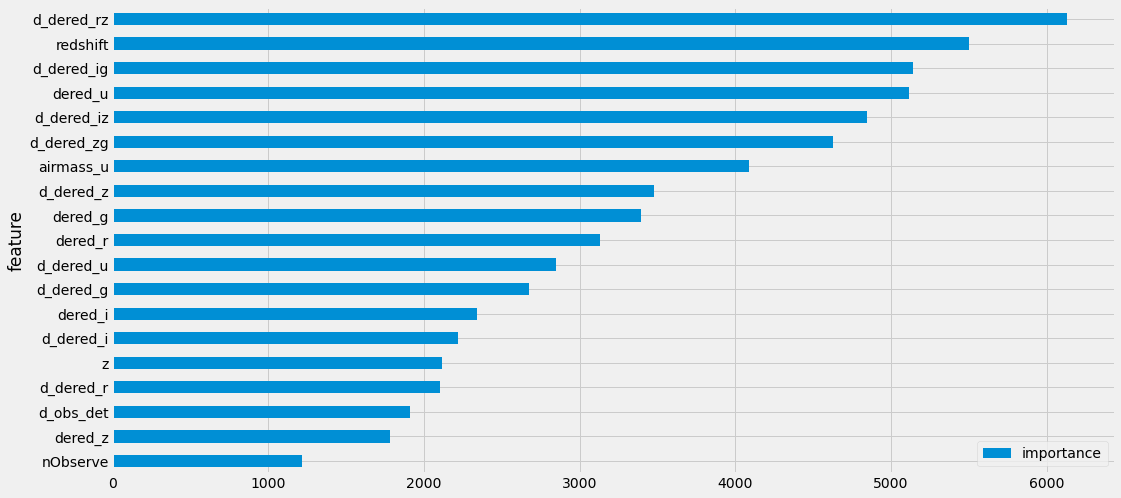

In [18]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

## 파일 형식 생성

In [19]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [20]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [21]:
sub[target_col].value_counts()

2    40993
0    29974
1     9033
Name: class, dtype: int64

In [22]:
sub.to_csv(sub_file)